Authentic image: C:\Users\Uma\Downloads\CASIA2\CASIA2\Au\Au_pla_30634.jpg


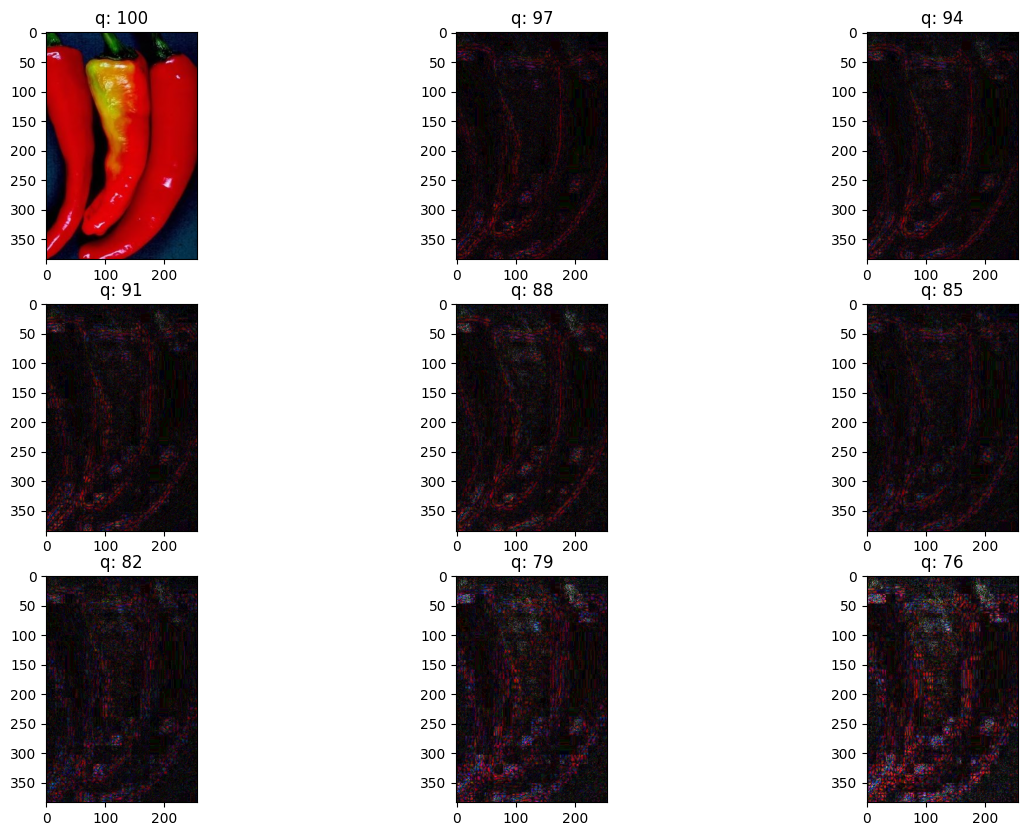

Tampered image: C:\Users\Uma\Downloads\CASIA2\CASIA2\Tp\Tp_D_CRN_M_N_nat10156_ani00001_12021.jpg


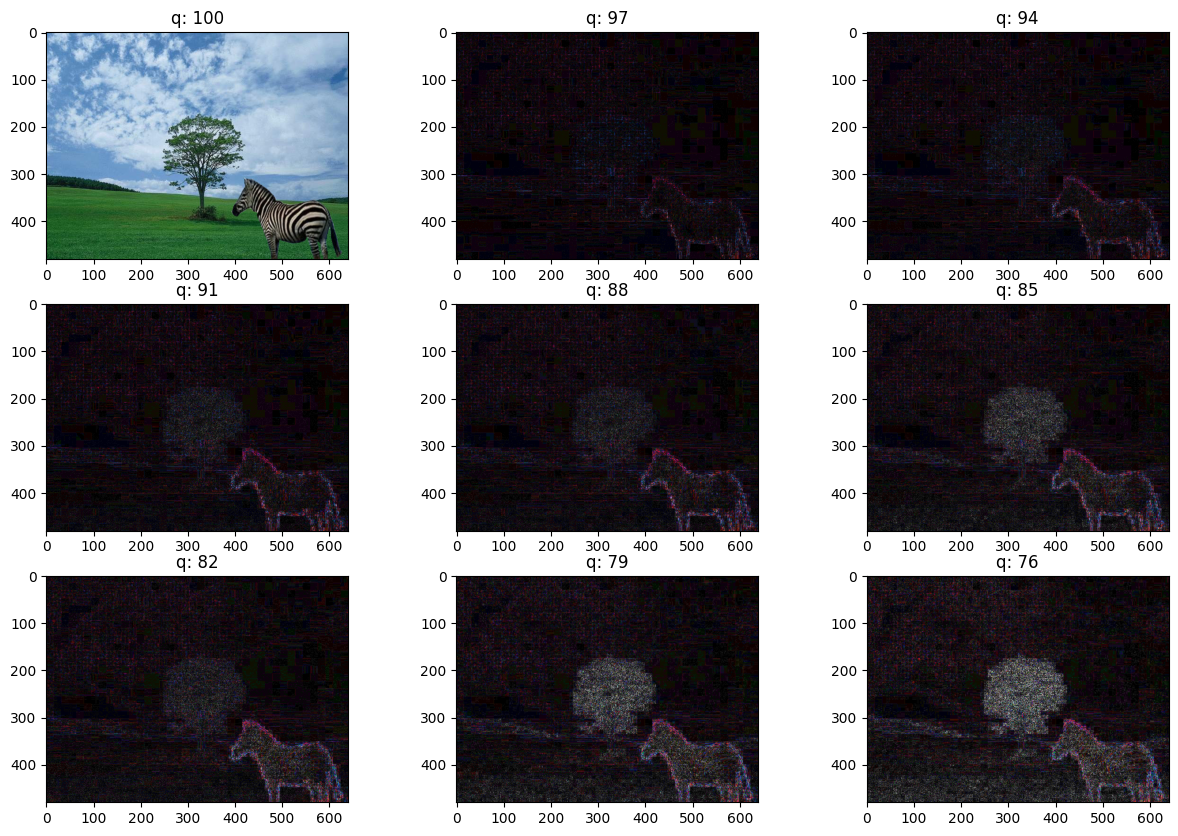

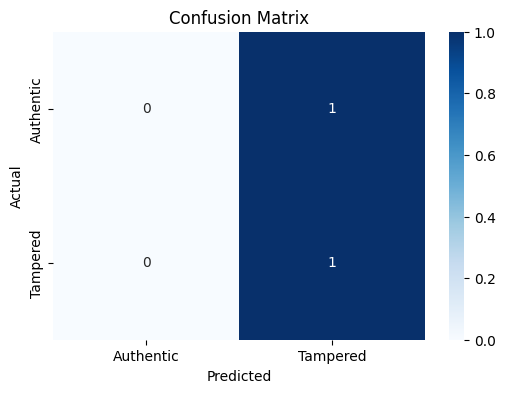

In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageChops, ImageEnhance
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to compute ELA using OpenCV
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpg'
    SCALE = 15
    orig_img = cv2.imread(path)
    if orig_img is None:
        raise ValueError(f"Image at {path} could not be read.")
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])
    compressed_img = cv2.imread(temp_filename)
    if compressed_img is None:
        raise ValueError("Compressed image could not be read.")
    
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff

# Function to randomly select an image from a directory
def random_sample(path, extension="jpg"):
    items = list(Path(path).rglob(f'*.{extension}'))
    items = [f for f in items if not f.name.startswith("._")]
    if not items:
        raise ValueError(f"No valid image files found in {path}")
    return str(random.choice(items))

# Paths to datasets
CASIA2_AU = r'C:\Users\Uma\Downloads\CASIA2\CASIA2\Au'
CASIA2_TP = r'C:\Users\Uma\Downloads\CASIA2\CASIA2\Tp'

# Load and visualize authentic image
authentic_path = random_sample(CASIA2_AU)
print(f"Authentic image: {authentic_path}")
orig = cv2.imread(authentic_path)
if orig is None:
    raise FileNotFoundError(f"Could not read image: {authentic_path}")
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0

# Plot ELA images for authentic image
init_val = 100
columns, rows = 3, 3
fig = plt.figure(figsize=(15, 10))
for i in range(1, columns * rows + 1):
    quality = init_val - (i - 1) * 3
    img = compute_ela_cv(authentic_path, quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

# Load and visualize tampered image
tampered_path = random_sample(CASIA2_TP)
print(f"Tampered image: {tampered_path}")
tampered = cv2.imread(tampered_path)
if tampered is None:
    raise FileNotFoundError(f"Could not read image: {tampered_path}")
tampered = cv2.cvtColor(tampered, cv2.COLOR_BGR2RGB) / 255.0

# Plot ELA images for tampered image
fig = plt.figure(figsize=(15, 10))
for i in range(1, columns * rows + 1):
    quality = init_val - (i - 1) * 3
    img = compute_ela_cv(tampered_path, quality)
    if i == 1:
        img = tampered.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

# Prepare confusion matrix data
true_labels = []
pred_labels = []

for path, label in [(authentic_path, 0), (tampered_path, 1)]:
    ela_img = compute_ela_cv(path, quality=90)
    mean_intensity = np.mean(ela_img)
    
    # Basic thresholding to classify
    threshold = 10.0
    prediction = 1 if mean_intensity > threshold else 0

    true_labels.append(label)
    pred_labels.append(prediction)

# Compute and plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Authentic', 'Tampered'],
            yticklabels=['Authentic', 'Tampered'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
